# EDLIF model

[Jaras I, Harada T, Orchard ME, Maldonado PE, Vergara RC. Extending the integrate-and-fire model to account for metabolic dependencies. Eur J Neurosci. 2021 Aug;54(4):5249-5260. doi: 10.1111/ejn.15326. Epub 2021 Jul 16. PMID: 34109698.](https://onlinelibrary.wiley.com/doi/10.1111/ejn.15326)

[Free full article](https://www.researchgate.net/publication/352298690_Extending_the_integrate-and-fire_model_to_account_for_metabolic_dependencies)

### TODO:
- [] include equations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
neuron_model = [
    "edlif_psc_base.nestml", 
    "edlif_psc_nonlineardendrite.nestml",
    "edlif_psc_supply_state.nestml",
    "edlif_psc_supply_inline.nestml",
    "edlif_psc_percent.nestml",
    "../network/models/neurons/edlif_psc_alpha_percent.nestml"
]
neuron_id = 5
generate_nest_target(input_path=neuron_model[neuron_id],
                     target_path="/tmp/nestml-component",
                     logging_level="INFO",
                     codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/wis/Documents/nestml/ehp/edlif/../network/models/neurons/edlif_psc_alpha_percent.nestml
[3,GLOBAL, INFO]: No module name specified; the generated module will be named "nestmlmodule"
[4,GLOBAL, INFO]: Start processing '/home/wis/Documents/nestml/ehp/edlif/../network/models/neurons/edlif_psc_alpha_percent.nestml'!
[6,edlif_psc_alpha_percent, INFO, [50:31;50:39]]: Implicit magnitude conversion from pA to pA buffer with factor 1.0 
[7,edlif_psc_alpha_percent, INFO, [50:13;50:22]]: Implicit magnitude conversion from mV / ms to pA / pF with factor 1.0 
[8,edlif_psc_alpha_percent, INFO, [21:15;21:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[9,edlif_psc_alpha_percent, INFO, [24:15;24:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[10,edlif_psc_alpha_percent, INFO, [25:15;25:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[11,edlif_psc_alpha_percent, INFO

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = -V_abs / tau_m + ((I_kernel_ex__X__exc_spikes - I_kernel_in__X__inh_spikes) + I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "ATP' = (((ATP_h - ATP) * K_ATP * homeostatic_s_enabled + ATP_basal) - ((ATP_basal + (E_ap_tr * E_ap / tau_ap / o_t) + ((ATP_kernel_ex__X__exc_spikes * E_syn_ex / tau_syn_atp_ex / w_max + ATP_kernel_in__X__inh_spikes * E_syn_in / tau_syn_atp_in / w_min) / o_t / 1.0)))) * o_t * (1 - fix_atp)",
            "initial_values": {
                "ATP": "100"
            }
        },
        {
            "expression": "I_kernel_in__X__inh_spikes = (e / tau_syn_in) * t * exp(-t / tau_syn_in)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel_ex__X__exc_spikes = (e / tau_syn_ex) * t * exp(-t / tau_syn_ex)",
            "initial_values": {}
    

INFO:Shape ATP_kernel_in__X__inh_spikes: reconstituting expression -ATP_kernel_in__X__inh_spikes/tau_syn_atp_in
INFO:Generating propagators for the following symbols: V_abs, ATP, I_kernel_in__X__inh_spikes, I_kernel_in__X__inh_spikes__d, I_kernel_ex__X__exc_spikes, I_kernel_ex__X__exc_spikes__d, ATP_kernel_ex__X__exc_spikes, ATP_kernel_in__X__inh_spikes
INFO:In ode-toolbox: returning outdict = 
INFO:[
    {
        "initial_values": {
            "ATP": "100",
            "ATP_kernel_ex__X__exc_spikes": "1",
            "ATP_kernel_in__X__inh_spikes": "1",
            "I_kernel_ex__X__exc_spikes": "0",
            "I_kernel_ex__X__exc_spikes__d": "e/tau_syn_ex",
            "I_kernel_in__X__inh_spikes": "0",
            "I_kernel_in__X__inh_spikes__d": "e/tau_syn_in",
            "V_abs": "0"
        },
        "parameters": {
            "ATP_h": "100.000000000000",
            "C_m": "250.000000000000",
            "E_ap": "15.0000000000000",
            "E_syn_ex": "8.00000000000000

[51,edlif_psc_alpha_percent, INFO, [24:15;24:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[52,edlif_psc_alpha_percent, INFO, [25:15;25:15]]: Implicit casting from (compatible) type 'integer' to 'real'.
[53,edlif_psc_alpha_percent, INFO, [68:17;68:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[54,edlif_psc_alpha_percent, INFO, [73:17;73:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[55,edlif_psc_alpha_percent, INFO, [74:16;74:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[56,edlif_psc_alpha_percent, INFO, [75:16;75:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[57,edlif_psc_alpha_percent, INFO, [76:16;76:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[58,edlif_psc_alpha_percent, INFO, [77:20;77:20]]: Implicit casting from (compatible) type 'integer' to 'real'.
[59,edlif_psc_alpha_percent, INFO, [78:20;78:20]]: Implicit casting from (compatible) type 'integer' to 

In [4]:
nest.Install("nestmlmodule")


Sep 27 18:11:12 Install [Info]: 
    loaded module nestmlmodule


resolution time: 0.1
Using neuron model: edlif_psc_alpha_percent
Using  current generator


/tmp/ipykernel_66859/2185078187.py:78: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


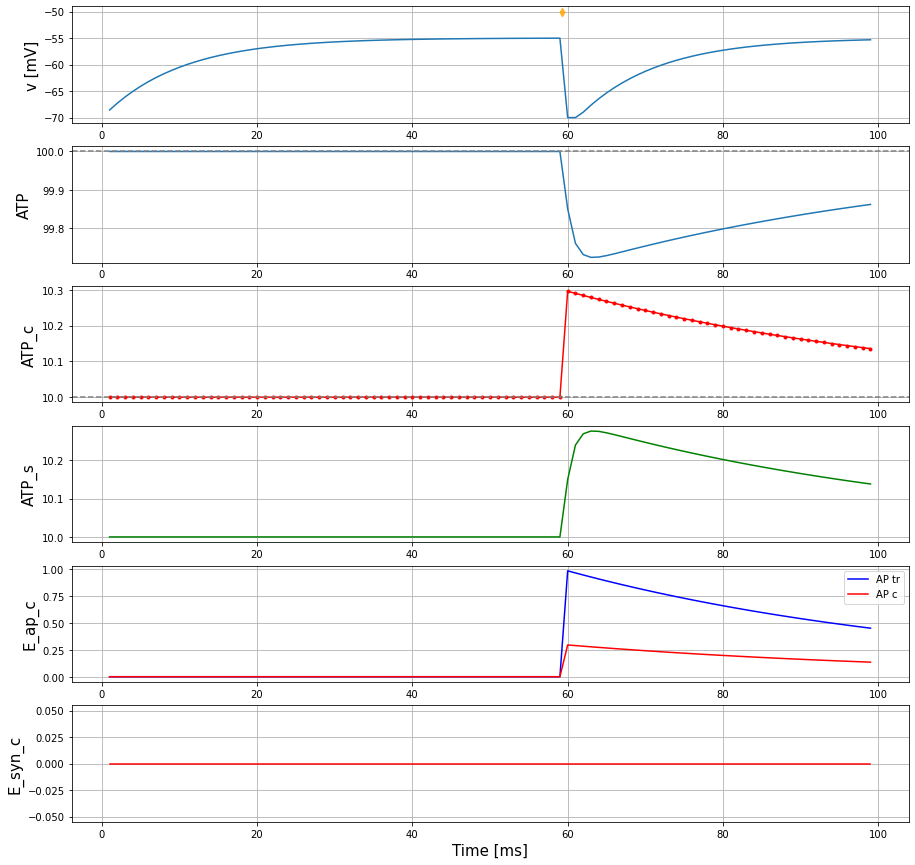

In [38]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

# resolution
nest.resolution = 0.1
resolution = nest.GetKernelStatus()["resolution"]
print(f"resolution time: {resolution}") 

neuron_model_name = neuron_model[neuron_id].split("/")[-1].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

# current generator
gen = "" # dc o ac
print(f"Using {gen} current generator")

neuron = nest.Create(neuron_model_name)
voltmeter = nest.Create("voltmeter")

# change neuron params
neuron.K_ATP = 1
neuron.I_e = 376
neuron.gamma = 0
neuron.tau_m = 10
neuron.t_ref = 2
#neuron.tau_syn_ex = 6
#neuron.tau_syn_in = 6

voltmeter.set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter, neuron)

if gen == "dc":
    cgs = nest.Create('dc_generator')
    cgs.set({"amplitude": 375.86})
elif gen == "ac":
    cgs = nest.Create('ac_generator')
    cgs.set({"amplitude": 150.2})
    cgs.set({"offset": 250.2})
    cgs.set({"frequency": 10})
if gen != "":    
    nest.Connect(cgs, neuron)

sr = nest.Create("spike_recorder")
nest.Connect(neuron, sr)

nest.Simulate(0.2*500.)

# precision
#error = nest.GetStatus(neuron, "gsl_error_tol")
#print(f"absolute error of integration: {error}")

spike_times = nest.GetStatus(sr, keys='events')[0]['times']

fontsize = 15
fig, ax = plt.subplots(nrows=6, figsize=(15,15))
ax[0].plot(voltmeter.get("events")["times"], voltmeter.get("events")["V_m"])
ax[1].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP"])
ax[1].axhline(y=neuron.get("ATP_h"), c="gray", ls="--")
ax[2].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP_c"], c="r", marker ='.')
ax[2].axhline(y=neuron.get("ATP_basal"), c="gray", ls="--")
ax[3].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP_s"], c="g")
ax[4].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr"], c="b", label="AP tr")
ax[4].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_c"], c="r", label="AP c")
#ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr2"], c="b")
#ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_der"], c="r")
ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_syn_c"], c="r")
ax[0].scatter(spike_times, -50 * np.ones_like(spike_times), marker="d", c="orange", alpha=.8, zorder=99)
for _ax in ax:
    _ax.grid(True)
ax[0].set_ylabel("v [mV]", fontsize=fontsize)
ax[1].set_ylabel("ATP", fontsize=fontsize)
ax[2].set_ylabel("ATP_c", fontsize=fontsize)
ax[3].set_ylabel("ATP_s", fontsize=fontsize)
ax[4].set_ylabel("E_ap_tr", fontsize=fontsize)
ax[4].set_ylabel("E_ap_c", fontsize=fontsize)
ax[5].set_ylabel("E_syn_c", fontsize=fontsize)
ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
ax[4].legend()
fig.show()

In [29]:
#nest.kernel_status